# Import libraries

In [1]:
from turbolpc import analysis, synthesis, utils
import numpy as np
import matplotlib.pyplot as plt
import time
from spectrum import arburg, arma2psd
from scipy import signal as sig

# Generate test data
Let us create a noisy signal with two peak frequency of 50 Hz and 500 Hz
We will create a vector of a single time series and a matrix with 10 copies of the same time series

In [2]:
Fs=10000 # sampling freq
t_length=10 # total seconds in timeseries
num_samples = t_length*Fs  # Number of samples
frequency1 = 50       # Frequency of the sinusoid signal
frequency2 = frequency1*10       # Frequency of the sinusoid signal
amplitude = 1       # Amplitude of the sinusoid signal
noise_level = 0.2   # Level of random noise

# Generate time vector
t = np.linspace(0, t_length, num_samples)

# Generate sinusoidal signal
sinusoid_signal = amplitude * np.sin(2 * np.pi * frequency1 * t)
sinusoid_signal = sinusoid_signal+ amplitude * np.sin(2 * np.pi * frequency2 * t)

# Generate random noise
np.random.seed(42)
noise = noise_level * np.random.randn(num_samples)

# Add noise to the sinusoidal signal
noisy_signal = sinusoid_signal +  noise

toydata_1D=noisy_signal
#toydata_2D=np.column_stack((toydata_1D,toydata_1D,toydata_1D))
# Repeat toydata_1D many times along the column axis
total_col=10
toydata_2D = np.tile(toydata_1D, (total_col, 1)).T

Plot data

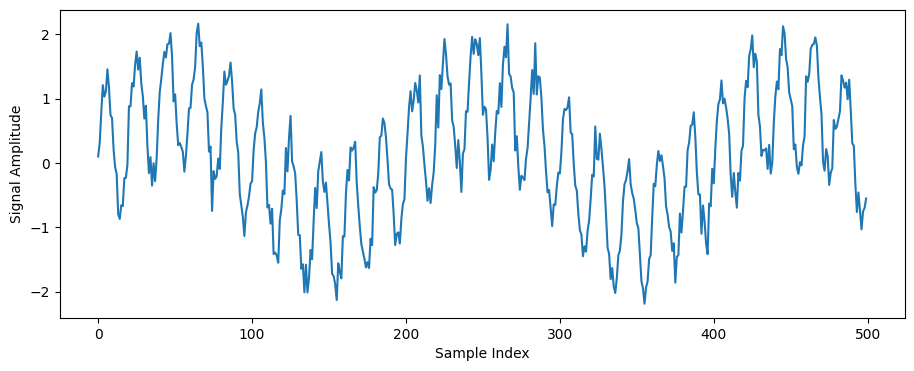

In [132]:
plt.figure(figsize=(10.9, 4))  # Adjust the figure aspect ratio
plt.plot(toydata_1D[:500])
plt.ylabel('Signal Amplitude')
plt.xlabel('Sample Index')
plt.show()

## Calculate LPC from timeseries data
Let us calculate LPC coefficients from the generated time series data using TurboLPC library and Spectrum library and observe whether we are getting the same results

In [20]:
lpc_order=2
a1,e1,r1=analysis.arburg_vector(x=toydata_1D,order=lpc_order)
print(f"Case: TurboLPC for vector data\n LPC coefficients: \n {a1}\n Reflection coeff: \n {r1} \n Sigma:{e1}\n")

AR, P, k = arburg(X=toydata_1D,order=lpc_order)
print(f"Case: Spectrum for vector data\n LPC coefficients: \n {AR}\n Reflection coeff: \n {k} \n Sigma:{P}\n")


a2,e2,r2=analysis.arburg_matrix(X=toydata_2D[:,:2],order=lpc_order)
print(f"Case: TurboLPC for 2-column matrix data\n LPC coefficients: \n {a2}\n Reflection coeff: \n {r2} \n Sigma:{e2}\n")



Case: TurboLPC for vector data
 LPC coefficients: 
 [-1.02039994  0.08811451]
 Reflection coeff: 
 [-0.93776889  0.08811451] 
 Sigma:0.12451220530079359

Case: Spectrum for vector data
 LPC coefficients: 
 [-1.02039994+0.j  0.08811451-0.j]
 Reflection coeff: 
 [-0.93776889+0.j  0.08811451-0.j] 
 Sigma:0.12451220530078196

Case: TurboLPC for 2-column matrix data
 LPC coefficients: 
 [[-1.02039994 -1.02039994]
 [ 0.08811451  0.08811451]]
 Reflection coeff: 
 [[-0.93776889 -0.93776889]
 [ 0.08811451  0.08811451]] 
 Sigma:[0.12451221 0.12451221]



## Performance Benchmark
We will compare the performance of TurboLPC with Spectrum

### Function for Performance comparison
Let's define a function for benchmarking where we do the operation of LPC 100 times and average the execution time

In [5]:
def get_timing(data,lpc_order,case_n):
    total_n=100
    timings=np.zeros((1,total_n))
    for i in range(total_n):
        start_time = time.time()
        if case_n==1:
            a1,e1,r1=analysis.arburg_vector(data,lpc_order)
        elif case_n==2:
            a2,e2,r2=analysis.arburg_matrix(data,lpc_order)
        elif case_n==3:
            AR, P, k = arburg(data,lpc_order)
        end_time = time.time()
        elapsed_time = end_time - start_time
        timings[0,i]=elapsed_time
    final_time=np.mean(timings)
    return final_time

### Run Benchmark
Let us now run the benchmark and collect performance data

In [6]:
lpc_order=6

ts_lengths=[1e1, 1e2, 1e3, 1e4, 1e5] 
time_turbolpc=np.zeros_like(ts_lengths)
time_spectrum=np.zeros_like(ts_lengths)

for i,ts in enumerate(ts_lengths):
    print(f"Case: {ts}")
    time_turbolpc[i]=get_timing(toydata_1D[:int(ts)],lpc_order,case_n=1)
    time_spectrum[i]=get_timing(toydata_1D[:int(ts)],lpc_order,case_n=3)    

Case: 10.0
Case: 100.0
Case: 1000.0
Case: 10000.0
Case: 100000.0


### Benchmark Results
Let us see the results which shows **1000x** performance gain in TurboLPC compared to Spectrum!

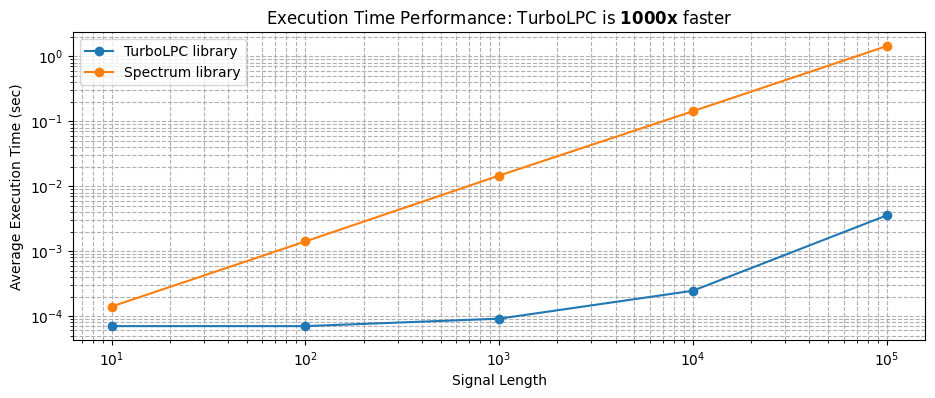

In [51]:
plt.figure(figsize=(11, 4))  # Adjust the figure aspect ratio
plt.loglog(ts_lengths, time_turbolpc, label="TurboLPC library", marker='o')  # Add markers
plt.loglog(ts_lengths, time_spectrum, label="Spectrum library", marker='o')  # Add markers
plt.title(r"Execution Time Performance: TurboLPC is $\bf{1000x}$ faster")
plt.legend()
plt.xlabel('Signal Length')
plt.ylabel('Average Execution Time (sec)')
plt.grid(True, which='both', linestyle='--')  # Optional: add grid for better readability
plt.show()



## Frequency-warped LPC

In [19]:
lpc_order=2 # LPC order
freq_warping=0.2 # Frequency warping coefficient

a1,e1,r1=analysis.arburg_warped_vector(x=toydata_1D,order=lpc_order,warp_factor=freq_warping)
print(f"Frequency-Warped LPC coefficients for single time series: \n {a1}\n Reflection coeff: \n {r1} \n Sigma:{e1}\n")


a2,e2,r2=analysis.arburg_warped_matrix(X=toydata_2D[:,:2],order=lpc_order,warp_factor=freq_warping)
print(f"Frequency-Warped LPC coefficients for 2-column matrix data: \n {a2}\n Reflection coeff: \n {r2} \n Sigma:{e2}")


Frequency-Warped LPC coefficients for single time series: 
 [-1.12880561  0.25150553]
 Reflection coeff: 
 [-0.90195815  0.25150553] 
 Sigma:0.1817696352513349

Frequency-Warped LPC coefficients for 2-column matrix data: 
 [[-1.12880561 -1.12880561]
 [ 0.25150553  0.25150553]]
 Reflection coeff: 
 [[-0.90195815 -0.90195815]
 [ 0.25150553  0.25150553]] 
 Sigma:[0.18176964 0.18176964]


## LPC and Cepstrum coefficients

In [23]:
lpc_order=2 # LPC order
a1,e1,r1=analysis.arburg_vector(x=toydata_1D,order=lpc_order)
print(f"LPC coefficients: \n {a1}\n\nReflection coeff: \n {r1} \n Sigma:{e1}\n")


c1=utils.arcoeff_to_cep(a=a1,sigma_squared=e1,N=4)
print(f"Cepstral Coefficient upto 4 elements: \n {c1}\n")

ac1=utils.cep_to_arcoeff(c=c1,order=lpc_order)
print(f"LPC from Cepstral Coefficient: \n {ac1}")


LPC coefficients: 
 [-1.02039994  0.08811451]

Reflection coeff: 
 [-0.93776889  0.08811451] 
 Sigma:0.12451220530079359

Cepstral Coefficient upto 4 elements: 
 [-2.08335153333792, 1.0203999393059906, 0.43249350582984936, 0.2642402170861366]

LPC from Cepstral Coefficient: 
 [-1.0203999393059906, 0.08811451223798528]


## Power spectrum from LPC
Let's calculate Power spectral density (PSD) using TurboLPC and Spectrum for both standard LPC and Frequency-warped LPC
- The signal has two frequency peaks: 50 Hz and 500 Hz. 
- Standard LPC tries to capture the whole spectrum with same resolution which fails to capture low peak at 50 Hz
- Frequency-warped LPC is a variation of LPC that estimates spectral powers in a non-uniform resolution
- Frequency-warped LPC with warping coefficient of 0.5 (higher resolution in low frequencies) captures boh 50 Hz and 500 Hz

In [27]:
lpc_order=20 # LPC order
freq_warping=0.5 # Frequency warping coefficient

a1,e1,r1=analysis.arburg_warped_vector(x=toydata_1D,order=lpc_order,warp_factor=freq_warping)
a1=utils.arcoeff_warp(a=a1,warp_factor=freq_warping,task="unwarp")
w1,pwr1=utils.freqz(a=a1,sigma_squared=e1,worN=2*Fs,fs=Fs)

a1,e1,r1=analysis.arburg_vector(x=toydata_1D,order=lpc_order)
w2,pwr2=utils.freqz(a=a1,sigma_squared=e1,worN=2*Fs,fs=Fs)


AR, P, k = arburg(X=toydata_1D,order=lpc_order)
PSD = arma2psd(AR, rho=P, NFFT=2**12)
PSD = PSD[len(PSD):len(PSD)//2:-1]

### Plot PSD


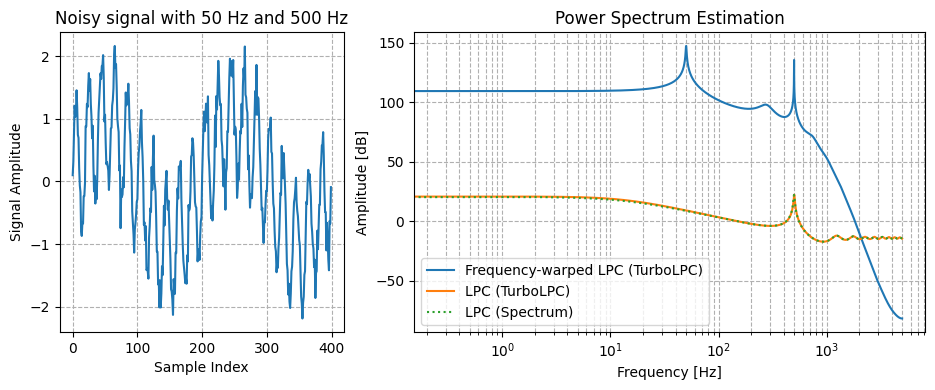

In [112]:
# Create a figure with a specified aspect ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

# First subplot
ax1.plot(toydata_1D[:400])
ax1.set_title('Noisy signal with 50 Hz and 500 Hz')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Signal Amplitude')
ax1.grid(True, which='both', linestyle='--')  # Optional: add grid for better readability

# Second subplot
ax2.semilogx(w1, pwr1, label="Frequency-warped LPC (TurboLPC)", linewidth=1.5)
ax2.semilogx(w2, pwr2, label="LPC (TurboLPC)", linewidth=1.5)
ax2.semilogx(np.linspace(0, Fs/2, len(PSD)), 10*np.log10(abs(PSD)), label='LPC (Spectrum)', linewidth=1.5, linestyle=':')
ax2.set_title('Power Spectrum Estimation')
ax2.legend(loc='lower left')  # Move the legend to the bottom left
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude [dB]')
ax2.grid(True, which='both', linestyle='--')  # Optional: add grid for better readability

# Adjust layout to prevent overlap
plt.tight_layout()

# Adjust the position of the second subplot to have less width
box = ax1.get_position()
ax1.set_position([box.x0 , box.y0, box.width * 0.6, box.height])
box = ax2.get_position()
ax2.set_position([box.x0 -.175, box.y0, box.width * 1.08, box.height])

# Show the combined figure
plt.show()

## Time series generation from LPC model parameters

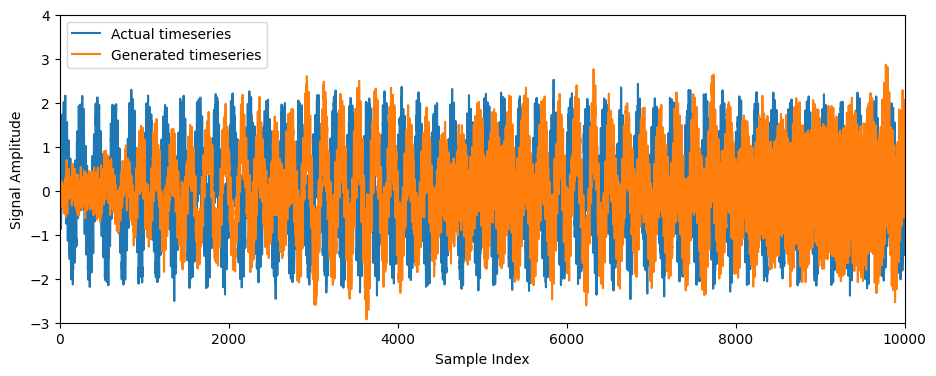

In [131]:
lpc_order=50 # LPC order
a1,e1,r1=analysis.arburg_vector(x=toydata_1D,order=lpc_order)

new_ts=synthesis.gen_ts(a=a1,sigma=np.sqrt(e1),n_samples=Fs)

plt.figure(figsize=(10.9, 4))  # Adjust the figure aspect ratio
plt.plot(toydata_1D[:Fs],label="Actual timeseries")
plt.plot(new_ts,label="Generated timeseries")
plt.xlim(0,10000)
plt.ylim(-3,4)
plt.ylabel('Signal Amplitude')
plt.xlabel('Sample Index')
plt.legend()
plt.show()

## Numerical accuracy of arcoeff_warp
arcoeff_warp uses scipy.signal.tf2zpk and scipy.signal.zpk2tf functions which are numerically inaccurate after 60th order.
We are going to test two things:
- Standard LPC and Frequency-warped LPC with 0 warping coefficient should provide same power spectrum
- LPC coefficients going through tf2zpk and zpk2tf should give identical results (x=tf2zpk(zpk2tf(x)))

In [114]:
# LPC parameters
freq_warping=0.0 # Frequency warping coefficient

lpc_orders=np.linspace(10,100,9)
error1=np.zeros_like(lpc_orders)
error2=np.zeros_like(lpc_orders)

for i, lpc_order in enumerate(lpc_orders):
    lpc_order=int(lpc_order)
    # PSD from frequency-warped LPC model
    a1,e1,r1=analysis.arburg_warped_vector(x=toydata_1D,order=lpc_order,warp_factor=freq_warping)
    a11=utils.arcoeff_warp(a=a1,warp_factor=freq_warping,task="unwarp")
    # PSD from LPC model
    a0,e0,r0=analysis.arburg_vector(x=toydata_1D,order=lpc_order)

    # show the problem in scipy.signal.tf2zpk and scipy.signal.zpk2tf functions
    a=np.insert(a11, 0, 1)
    b=np.zeros_like(a)
    b[0]=1
    b2,a2=sig.zpk2tf(*sig.tf2zpk(b, a))

    error1[i]=np.linalg.norm(a0-a11)
    error2[i]=np.linalg.norm(a-a2)


### Error Plot 

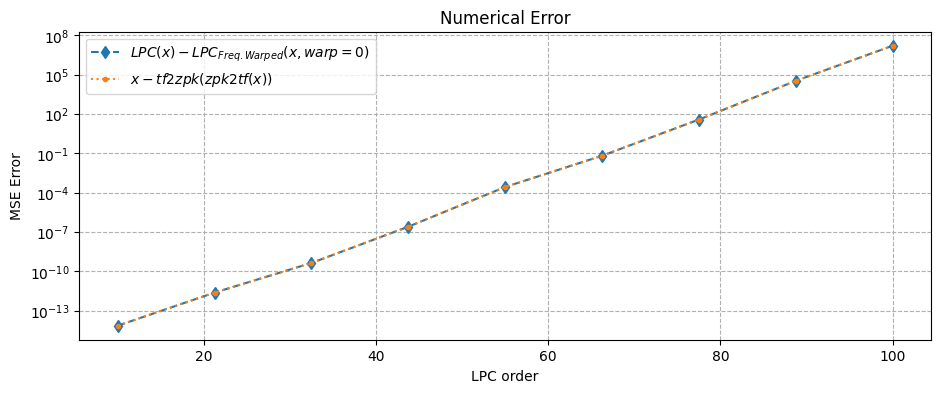

In [127]:
# plot
plt.figure(figsize=(11, 4))
plt.semilogy(lpc_orders,error1,label=r"$LPC(x)-LPC_{Freq. Warped}(x,warp=0)$", marker='d', linestyle='--')
plt.semilogy(lpc_orders,error1,label=r"$x-tf2zpk(zpk2tf(x))$", marker='.', linestyle=':')
plt.title('Numerical Error')
plt.grid(True, which='both', linestyle='--')  # Optional: add grid for better readability
plt.legend()
plt.xlabel('LPC order')
plt.ylabel('MSE Error')
plt.show()